In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform, randint

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
base_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle-PUBG/data/'
train_data = pd.read_csv(base_path + 'train_V2.csv')

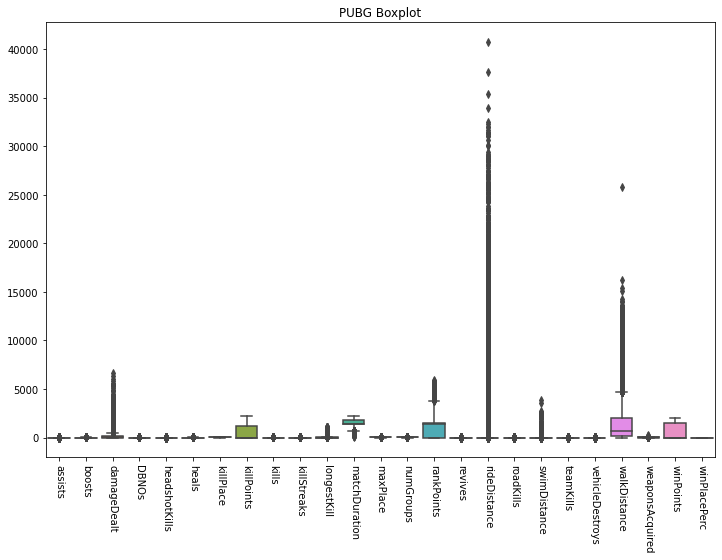

In [19]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data)
plt.xticks(rotation=-90)
plt.title('PUBG Boxplot')
plt.show()

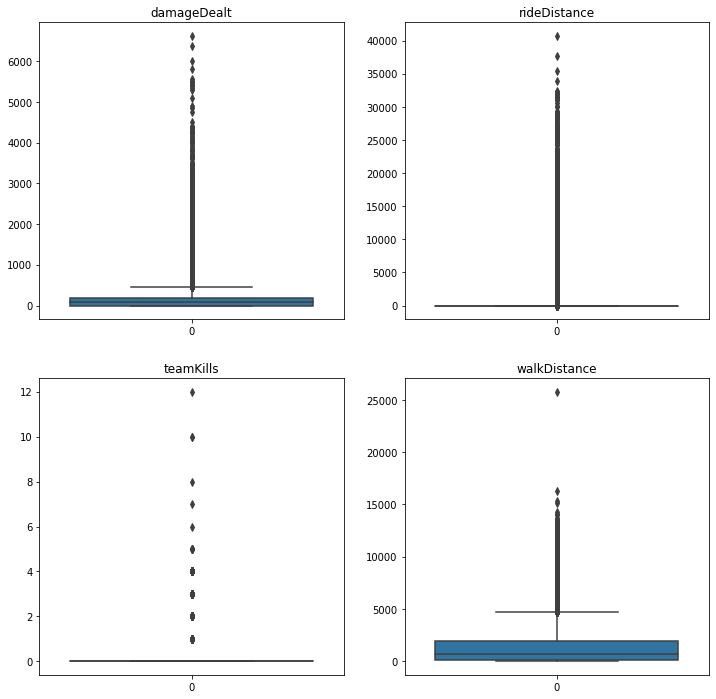

In [20]:
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.boxplot(data=train_data['damageDealt'])
plt.title("damageDealt")
plt.subplot(222)
sns.boxplot(data=train_data['rideDistance'])
plt.title("rideDistance")
plt.subplot(223)
sns.boxplot(data=train_data['teamKills'])
plt.title("teamKills")
plt.subplot(224)
sns.boxplot(data=train_data['walkDistance'])
plt.title("walkDistance")
plt.show()

In [21]:
train_data[(train_data.maxPlace <= 5) & (train_data.winPlacePerc == 0)][['damageDealt','kills','weaponsAcquired', 'walkDistance', 'winPlacePerc', 'maxPlace']]


,damageDealt,kills,weaponsAcquired,walkDistance,winPlacePerc,maxPlace
20384,63.03,0,3,3033.0,0.0,4
22420,0.00,0,6,841.4,0.0,4
33256,579.60,3,12,0.0,0.0,2
41242,746.00,10,17,2400.0,0.0,3
51361,100.00,1,2,129.3,0.0,2
...,...,...,...,...,...,...
4435972,1248.00,10,17,614.2,0.0,5
4438715,700.90,8,22,784.4,0.0,3
4440898,90.83,1,8,0.0,0.0,2
4441098,661.50,7,13,186.6,0.0,2


In [6]:
def drop_evert_game(df):
    drop_event = ['crashfpp', 'flaretpp', 'flarefpp', 'crashtpp']
    for i in drop_event:
        indexNames = df[df['matchType'].str.contains(i)].index
        df.drop(indexNames,  inplace=True)
    return df

In [7]:
def hack_users(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    ### Anomalies in aim 1 (More than 50 kills) ###
    hack_users = pd.concat([hack_users, df[df['kills'] >= 40]])
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    hack_users = pd.concat([hack_users, df[df['headshotKills'] >= 15]])
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    hack_users = pd.concat([hack_users, df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)]])
    ### Anomalies in aim 3 (Longest kill) ###
    hack_users = pd.concat([hack_users, df[df['longestKill'] >= 1000]])
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    hack_users = pd.concat([hack_users, df[df['DBNOs'] >= 20]])
    ### Anomalies in movement ###
    # walkDistance anomalies
    hack_users = pd.concat([hack_users, df[df['walkDistance'] >= 10000]])
    # rideDistance anomalies
    hack_users = pd.concat([hack_users, df[df['rideDistance'] >= 25000]])
    # swimDistance anomalies
    hack_users = pd.concat([hack_users, df[df['swimDistance'] >= 1500]])
    ### Anomalies in item 2 (heals) ###
    hack_users = pd.concat([hack_users, df[df['heals'] >= 40]])
    ### Anomalies in item 3 (boosts) ###
    hack_users = pd.concat([hack_users, df[df['boosts'] >= 15]])
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    hack_users = pd.concat([hack_users, df[df['killStreaks'] >= 10]])
    # revive zombies (revives >= 10)
    hack_users = pd.concat([hack_users, df[df['revives'] >= 10]])
    #Weapon master (weaponsAcquired >= 50)
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    #team killer.append(troll ( teamkills > 4)
    hack_users = pd.concat([hack_users, df[df['teamKills'] >= 50]])
    # Too little walkDistance
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)]])
    # superman ?
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)]])
    # Maybe cheater & Gosu
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)]])
    return hack_users

In [8]:
def drop_hackuser_include_game(df):
    hack_user = hack_users(df)
    df.drop(columns='headshot_rate', inplace=True)
    hack_user.drop(columns='headshot_rate', inplace=True)
    hack_user = hack_user.drop_duplicates('Id') # 핵 중복 사용 유저 정리

    # 핵유저 포함된 경기 ID 
    hack_user_matchid = str(list(hack_user.matchId.values))

    # 
    df["hack_user_game"] = df.matchId.apply(lambda x : 0 if hack_user_matchid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환
    df = df[df.hack_user_game == 0]
    df = df.drop(columns='hack_user_game')
    return df


In [9]:
# add match_type_numerical
def divide_match_type(x):
    if x.find('solo') != -1:
        return 0
    elif x.find('duo') != -1:
        return 1
    else:
        return 2

def preprocessing(test_data):
    test_data['match_type_numerical'] = test_data['matchType'].apply(lambda x : divide_match_type(x) )

    # add maptype
    test_data['maptype'] = test_data['matchDuration'].apply(lambda x : 0 if x<1600 else 1)

    # add team members
    test_data['team_members'] = test_data.groupby('groupId').Id.transform('count')

    # drop colums
    drop_columns = ['killStreaks','headshotKills', 'assists', 'matchDuration','matchType', 'swimDistance', 'vehicleDestroys', 'roadKills', 'DBNOs', 'revives', 'teamKills','killPoints', 'winPoints', 'rankPoints', 'numGroups' ]
    test_data = test_data.drop(columns=drop_columns).copy()
    return test_data

In [26]:
'groupId', 'Id', 'matchId'

('groupId', 'Id', 'matchId')

In [10]:
def best_player(x):
    # print(x)
    a = x.walkDistance.idxmax()
    return x.loc[a, :]



In [11]:
def select_teamdata_type(df, n):

    if n == 0:  # 합계    
        team_df_sum = df.iloc[:, :-3].groupby(['matchId', 'groupId']).agg(sum)
        team_df_mean = df[['matchId', 'groupId','winPlacePerc', 'team_members', 'match_type_numerical']].groupby(['matchId', 'groupId']).agg(np.mean)
        team_df = pd.concat([team_df_sum, team_df_mean], axis=1, ignore_index=False)
        
    elif n ==1: # 평균
        team_df = df.groupby(['matchId', 'groupId']).agg(np.mean)

    else:       #best player
        team_df = df.loc[train_data.groupby(['groupId'])['walkDistance'].idxmax()]
        

    return team_df

In [12]:
train_data = drop_evert_game(train_data)

In [13]:
train_data = drop_hackuser_include_game(train_data)

In [14]:
train_data = preprocessing(train_data)

In [15]:
train_data = select_teamdata_type(train_data, 1) # sum : 0 , mean : 1, best player : 2

In [34]:
train_data

boosts  damageDealt     heals  killPlace  \
matchId        groupId                                                      
0000a43bce5eec 18b16ec699d8b6  0.500000   109.675000  0.500000  41.000000   
               236ab9e9c081b9  0.000000    47.988333  0.000000  90.500000   
               3a6addfa0df938  0.000000     0.000000  0.000000  94.500000   
               4bf06994bd4c9a  0.500000    11.700000  0.000000  59.500000   
               4d1bbbc19b9084  3.500000   340.950000  1.000000  14.000000   
...                                 ...          ...       ...        ...   
fffe92232706aa b671eab579d429  0.000000    16.950000  0.000000  29.000000   
               bd5b4ecf8067ab  2.666667   205.676667  6.666667  19.333333   
               c8e95cc6c06d41  0.000000    25.950000  0.000000  82.000000   
               d57f3a3ed40913  0.500000    59.750000  0.500000  60.750000   
               d8fa9cfd6f9560  1.285714   104.414286  1.857143  42.000000   

                                  kills  longestKill  maxPlace  rideDistance  \
matchId        groupId                                                         
0000a43bce5eec 18b16ec699d8b6  1.000000     6.275000      28.0      0.000000   
               236ab9e9c081b9  0.000000     0.000000      28.0      0.000000   
               3a6addfa0df938  0.000000     0.000000      28.0      0.000000   
               4bf06994bd4c9a  0.000000     0.000000      28.0      0.000000   
               4d1bbbc19b9084  3.000000    25.230000      28.0     79.953000   
...                                 ...          ...       ...           ...   
fffe92232706aa b671eab579d429  1.000000    32.990000      29.0   1732.000000   
               bd5b4ecf8067ab  1.333333   116.104333      29.0   4301.000000   
               c8e95cc6c06d41  0.166667     1.334833      29.0      0.000000   
               d57f3a3ed40913  0.250000     0.544250      29.0      0.000000   
               d8fa9cfd6f9560  0.571429    21.894143      29.0    845.671429   

                               walkDistance  weaponsAcquired  winPlacePerc  \
matchId        groupId                                                       
0000a43bce5eec 18b16ec699d8b6    131.685000         1.000000        0.3333   
               236ab9e9c081b9     19.931833         0.833333        0.0370   
               3a6addfa0df938      4.818000         0.500000        0.0000   
               4bf06994bd4c9a    559.050000         7.000000        0.3704   
               4d1bbbc19b9084   3292.500000         4.000000        1.0000   
...                                     ...              ...           ...   
fffe92232706aa b671eab579d429   2988.000000         3.000000        0.6429   
               bd5b4ecf8067ab   2023.000000         7.666667        0.9286   
               c8e95cc6c06d41     91.383333         0.666667        0.0000   
               d57f3a3ed40913    292.180000         2.750000        0.2500   
               d8fa9cfd6f9560   1380.671429         4.714286        0.4643   

                               match_type_numerical  maptype  team_members  
matchId        groupId                                                      
0000a43bce5eec 18b16ec699d8b6                   2.0      0.0           2.0  
               236ab9e9c081b9                   2.0      0.0           6.0  
               3a6addfa0df938                   2.0      0.0           2.0  
               4bf06994bd4c9a                   2.0      0.0           2.0  
               4d1bbbc19b9084                   2.0      0.0           2.0  
...                                             ...      ...           ...  
fffe92232706aa b671eab579d429                   2.0      1.0           1.0  
               bd5b4ecf8067ab                   2.0      1.0           3.0  
               c8e95cc6c06d41                   2.0      1.0           6.0  
               d57f3a3ed40913                   2.0      1.0           4.0  
               d8fa9cfd6f9560                   2.0

In [ ]:
# temp.to_csv(base_path + 'best_player_team.csv')

In [ ]:
# base_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle-PUBG/data/'
# temp = pd.read_csv(base_path + 'best_player_team.csv')

In [16]:
train_data = train_data.reset_index()

In [17]:
train_data[train_data['winPlacePerc'].isna()]
train_data.drop(index=train_data[train_data['matchId']== '224a123c53e008'].index, inplace=True)

In [18]:
train_data = train_data.drop(columns=['groupId', 'matchId'])

In [48]:
train_data = train_data.drop(columns=['killPlace', 'team_members'])

KeyError: ignored

In [49]:
train_data

,boosts,damageDealt,heals,kills,longestKill,maxPlace,rideDistance,walkDistance,weaponsAcquired,winPlacePerc,match_type_numerical,maptype
0,0.500000,109.675000,0.500000,1.000000,6.275000,28.0,0.000000,131.685000,1.000000,0.3333,2.0,0.0
1,0.000000,47.988333,0.000000,0.000000,0.000000,28.0,0.000000,19.931833,0.833333,0.0370,2.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,28.0,0.000000,4.818000,0.500000,0.0000,2.0,0.0
3,0.500000,11.700000,0.000000,0.000000,0.000000,28.0,0.000000,559.050000,7.000000,0.3704,2.0,0.0
4,3.500000,340.950000,1.000000,3.000000,25.230000,28.0,79.953000,3292.500000,4.000000,1.0000,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1971586,0.000000,16.950000,0.000000,1.000000,32.990000,29.0,1732.000000,2988.000000,3.000000,0.6429,2.0,1.0
1971587,2.666667,205.676667,6.666667,1.333333,116.104333,29.0,4301.000000,2023.000000,7.666667,0.9286,2.0,1.0
1971588,0.000000,25.950000,0.000000,0.166667,1.334833,29.0,0.000000,91.383333,0.666667,0.0000,2.0,1.0
1971589,0.500000,59.750000,0.500000,0.250000,0.544250,29.0,0.000000,292.180000,2.750000,0.2500,2.0,1.0


#Modeling

In [19]:
X = train_data.drop(columns='winPlacePerc').copy()
y = train_data['winPlacePerc']

In [20]:
from sklearn.linear_model import LinearRegression   # 1. Linear Regression
from sklearn.linear_model import Lasso              # 2. Lasso
from sklearn.linear_model import Ridge              # 3. Ridge
from xgboost.sklearn import XGBRegressor            # 4. XGBoost
from lightgbm.sklearn import LGBMRegressor          # 5. LightGBM
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import r2_score


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

- split

In [21]:
X_train ,X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state=0xC0FFEE)
print(X_train.shape,y_train.shape)

(1577272, 13) (1577272,)


In [22]:
## 스케일링 
from sklearn.preprocessing import  StandardScaler
X_list =X.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [54]:
import lightgbm as lgb
train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_test, label = y_test) 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0).fit(X_train, y_train)
rf_score = rf_model.score(X_test, y_test) * 100
np.round(rf_score, 2)
y_pred_rf = rf_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_rf))

In [56]:
dt_model = DecisionTreeRegressor(random_state=0xC0FFEE).fit(X_train, y_train)
y_pred_xgb = dt_model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred_xgb))


MAE: 0.10190662847322392


In [ ]:
feature_importance = dt_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# feature scaling
reg = LinearRegression()
reg2= Lasso()
reg3= Ridge()
reg4=XGBRegressor()
reg5=LGBMRegressor()
reg6=DecisionTreeRegressor()

reg.fit(X_train , y_train)
reg2.fit(X_train , y_train)
reg3.fit(X_train , y_train)
reg4.fit(X_train , y_train)
reg5.fit(X_train , y_train)
reg6.fit(X_train , y_train)

pred_train = reg.predict(X_train)
pred_train2 = reg2.predict(X_train)
pred_train3 = reg3.predict(X_train)
pred_train4 = reg4.predict(X_train)
pred_train5 = reg5.predict(X_train)
pred_train6 = reg5.predict(X_train)

mae_train = mean_absolute_error(y_train, pred_train)
mae_train2 = mean_absolute_error(y_train, pred_train2)
mae_train3 = mean_absolute_error(y_train, pred_train3)
mae_train4 = mean_absolute_error(y_train, pred_train4)
mae_train5 = mean_absolute_error(y_train, pred_train5)
mae_train6 = mean_absolute_error(y_train, pred_train5)

In [20]:
model_list = [LinearRegression(),Lasso(), XGBRegressor(random_state =0xC0FFEE), LGBMRegressor(random_state =0xC0FFEE)]

In [23]:
model_list = [XGBRegressor(random_state =0xC0FFEE), LGBMRegressor(random_state =0xC0FFEE)]


In [24]:
for i in model_list:
    reg = i
    reg.fit(X_train , y_train)
    pred_train = reg.predict(X_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    print(f"{i} train=%.4f" % (mae_train))

[06:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(random_state=12648430) train=0.0607
LGBMRegressor(random_state=12648430) train=0.0535


In [25]:
reg5=LGBMRegressor(random_state =0xC0FFEE)
reg5.fit(X_train , y_train)
pred_train5 = reg5.predict(X_train)
mae_train5 = mean_absolute_error(y_train, pred_train5)
print(f"{i} train=%.4f" % (mae_train5))

LGBMRegressor(random_state=12648430) train=0.0535


In [27]:
test = pd.read_csv(base_path + 'test_V2.csv')
submission = pd.read_csv(base_path + 'sample_submission_V2.csv')

In [29]:
test = preprocessing(test)

In [33]:
test = test.drop(columns=['Id', 'groupId', 'matchId'])

In [34]:
predict_lgbm = reg5.predict(test)

In [35]:
predict_lgbm

array([0.44928087, 0.58801834, 0.46442981, ..., 0.51749971, 0.59056827,
       0.44861132])

In [37]:
submission.winPlacePerc = predict_lgbm

In [41]:
submission.to_csv('submission.csv', index=False)

In [40]:
submission

,Id,winPlacePerc
0,9329eb41e215eb,0.449281
1,639bd0dcd7bda8,0.588018
2,63d5c8ef8dfe91,0.464430
3,cf5b81422591d1,0.476853
4,ee6a295187ba21,0.597541
...,...,...
1934169,a316c3a13887d5,0.585852
1934170,5312146b27d875,0.496044
1934171,fc8818b5b32ad3,0.517500
1934172,a0f91e35f8458f,0.590568


In [ ]:
print("1. Linear Regression\t, train=%.4f" % (mae_train))
print("2. Lasso\t\t, train=%.4f" % (mae_train2))
print("3. Ridge\t\t, train=%.4f" % (mae_train3))
print("4. XGBoost\t\t, train=%.4f" % (mae_train4))
print("5. LightGBM\t\t, train=%.4f" % (mae_train5))

In [ ]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2022}

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, predict_test)
# r2 = r2_score(y_test, predict_test)
print('Mean squared error: ', mse)
# print('R2 score: ', r2)

In [ ]:
mean_absolute_error(y_test, predict_test)

0.07216399499752017

In [ ]:
# Hyper-parameter tuning

# GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth":[3, 5, -1],
    "learning_rate":[0.1,0.01],
    "n_estimators" : [50,100,200]
}

gcv = GridSearchCV(reg5, param_grid,scoring='neg_mean_squared_error',verbose=1)
gcv.fit(X_train , y_train)
print(gcv.best_estimator_)
print(gcv.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
LGBMRegressor(n_estimators=200)
{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200}



Fitting 5 folds for each of 18 candidates, totalling 90 fits
LGBMRegressor(n_estimators=200)
{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200}

In [ ]:
final_model = gcv.best_estimator_
final_model

LGBMRegressor(n_estimators=200)

In [ ]:
# prediction!
result = reg.predict(X_test)
result2= reg2.predict(X_test)
result3 = reg3.predict(X_test)
result4 = reg4.predict(X_test)
result5 = reg5.predict(X_test)

In [ ]:
# Summary!
print("---------- Linear Regression ---------")
print('MSE in training: %.4f' % mean_squared_error(y_test, result))

print("---------- Lasso ---------")
print('MSE in training: %.4f' % mean_squared_error(y_test, result2))

print("---------- Ridge ---------")
print('MSE in training: %.4f' % mean_squared_error(y_test, result3))

print("---------- XGBoost ---------")
print('MSE in training: %.4f' % mean_squared_error(y_test, result4))

print("---------- LightGBM ---------")
print('MSE in training: %.4f' % mean_squared_error(y_test, result5))

---------- Linear Regression ---------
MSE in training: 0.0170
---------- Lasso ---------
MSE in training: 0.0886
---------- Ridge ---------
MSE in training: 0.0170
---------- XGBoost ---------
MSE in training: 0.0094
---------- LightGBM ---------
MSE in training: 0.0090


##XGBRegressor

In [ ]:
from sklearn.model_selection import train_test_split,cross_validate

In [ ]:
Xgbr=XGBRegressor(n_estimators=400,learning_rate=0.1 , max_depth=3 , objective = 'reg:squarederror')
Xgbr.fit(X_train,y_train)
preds=Xgbr.predict(X_test)

In [ ]:
cross_val=cross_validate(
    estimator= Xgbr,
    X = X, y=y,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(),cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(),cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(),cross_val['test_score'].std()))

KeyboardInterrupt: ignored

In [ ]:
predict_train = Xgbr.predict(X_train)
predict_test = Xgbr.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, predict_test)
mae = mean_absolute_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)
print('Mean squared error: ', mse)
print('Mean absolute error: ', mae)
print('R2 score: ', r2)

In [ ]:
from xgboost import plot_importance
fig , ax= plt.subplots(figsize = (10,12))
plot_importance(Xgbr,ax=ax);


In [ ]:
X

In [ ]:
from xgboost import plot_importance
ft_importance_values = Xgbr.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [ ]:
dot_data = xgb.to_graphviz(Xgbr)
graph = graphviz.Source(dot_data)
graph

1.   f8에 대해서 분기를 가진다 (Walkdistance)
2.   f3에 대해서 분기를 가진다 (Killplace)

depth 3 

In [ ]:
import lightgbm as lgb
train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_test, label = y_test) 

In [ ]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2022}

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, predict_test)
mae = mean_absolute_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)
print('Mean squared error: ', mse)
print('Mean absolute error: ', mae)
print('R2 score: ', r2)

Mean squared error:  0.008860550434675247
Mean absolute error:  0.07206819670147654
R2 score:  0.9001073950968664

In [ ]:
%%time
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
model = LGBMRegressor()
model.fit(X_train, y_train,eval_metric ='mae', verbose=20)
pred = model.predict(X_test)
print(f"MSE : {mean_squared_error(y_test, pred):.3}")
print(f"MAE : {mean_absolute_error(y_test, pred):.3}")


##LightGBM